# Syntetic Data Test - Credit Classifier Pipeline Build Notebook (Experimental)

## Challenge: how to tackle imbalanced classes and sparse matrix processing

## ML Pipeline Flow:

Data source is generated data of 50000 records and a mix of catigorical & numerical features, 
transformed using a DBT ETL worklow to extract data from generator and apply a is_default target column based on below logic; 

```sql
CASE
    WHEN credit_amount > 15000 AND duration > 36 THEN 1
    WHEN job IN ('unemployed', 'unskilled') AND housing = 'free' THEN 1
    WHEN purpose = 'radio/tv' AND credit_amount > 12000 THEN 1
    ELSE 0
```


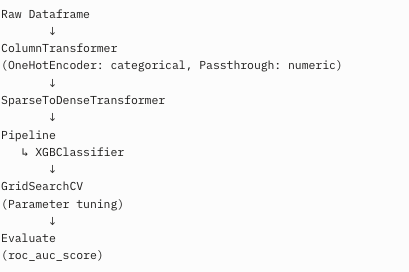


In [11]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import xgboost as xgb
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import issparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import joblib


In [3]:
#Load Data from PostgreSQL
import pandas as pd
from sqlalchemy import create_engine

db_config = {
    "user": "postgres",
    "password": "password",
    "host": "localhost",
    "port": 5432,
    "database": "credit_etl"
}

engine = create_engine(f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

#load data 

query1 = "select * from raw.stg_credit_data"
query2 = "select * from raw.credit_score_summary"

credit_data = pd.read_sql(query1, engine)
#credit_score_summary = pd.read_sql(query2, engine)

credit_data.head()
#credit_score_summary()

,customer_id,age,job,credit_amount,duration,housing,purpose,is_default
0,1,39,blue-collar,2260,53,own,car,0
1,2,33,blue-collar,837,11,free,business,0
2,3,41,services,1767,48,rent,education,0
3,4,50,management,536,8,rent,education,0
4,5,32,admin,1334,31,own,car,0


## Describe data and check for imbalanced classes in the dataset and data leakage 

In [4]:
credit_data.describe()

,customer_id,age,credit_amount,duration,is_default
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,250000.500000,34.696528,2992.515406,32.496696,0.008084
std,144337.711635,9.575200,2974.415204,15.581748,0.089547
min,1.000000,18.000000,100.000000,6.000000,0.000000
25%,125000.750000,28.000000,863.000000,19.000000,0.000000
50%,250000.500000,34.000000,2071.000000,33.000000,0.000000
75%,375000.250000,41.000000,4149.000000,46.000000,0.000000
max,500000.000000,75.000000,20000.000000,59.000000,1.000000


In [5]:
print(credit_data.duplicated().sum())

0


In [6]:
print(credit_data['is_default'].value_counts(normalize=True))

is_default
0    0.991916
1    0.008084
Name: proportion, dtype: float64


The class distribution shows that there a significant class imbalance in your dataset, with 99% of the instances being non-default (class 0) and rest of the instances being default (class 1). This imbalance could be contributing to high AUC scores, especially if the model is predicting the majority class (0—non-default) most of the time.

In such imbalanced datasets, AUC can sometimes be misleading since a model that always predicts the majority class (non-default) can still achieve a high AUC. This happens because the ROC curve rewards a model that ranks the positive class (default) higher than the negative class (non-default), but it might not reflect the actual predictive power when the dataset is highly imbalanced.


In [ ]:
x = credit_data.drop(columns= ['is_default', 'customer_id'])
y = credit_data['is_default']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

#custom transformer to convert sparse matrix to dense array
class SparseToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, x, y='none'):
        return self #nothing to learn so return self
        
    def transform(self, x):
        if issparse(x):
            return x.toarray() # convert sparse to dense
        return x # already dense return



categorical_cols = ['job', 'housing', 'purpose']
numerical_cols = ['age', 'duration','credit_amount']

# Calculate the class weight ratio for imbalanced classes
class_weight_ratio = len(y_train) / (2 * y_train.value_counts().min())


#define the column transformer with OneHotEncoder
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy='auto')

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('to_dense', SparseToDenseTransformer()),
    ('smote',SMOTE(random_state=42)),#SMOTE to handle class imbalance
    ('clf', XGBClassifier(eval_metric='auc', random_state=42, scale_pos_weight=class_weight_ratio))
])


# Define the scoring method for cross-validation (AUC in this case)
scoring = make_scorer(roc_auc_score)

param_grid = {
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_depth': [3],
    'clf__learning_rate': [0.1, 0.01],
    'clf__subsample': [0.8],
    'clf__reg_alpha': [0, 0.1],  # L1 regularization
    'clf__reg_lambda': [1, 10]      # L2 regularization
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           scoring=scoring, cv=cv, verbose=1, n_jobs=-1)

grid_search.fit(x_train, y_train)  # optional, suppress per-iteration output

best_params = grid_search.best_params_
print('Best Params:', best_params)
print("Best AUC:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(x_test)[:,1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on test set: {test_auc:.4f}")
                                 


Fitting 10 folds for each of 32 candidates, totalling 320 fits


## 1. Validate AUC on Test Set:

* Check AUC on your test set (data that the model hasn’t seen) to confirm that the model generalizes well.

* Check for Overfitting: Plot training vs. validation loss (or AUC). If the training AUC is much higher than the validation/test AUC, you might be overfitting.

* Use Cross-Validation: Use cross-validation to estimate the stability of your AUC and avoid relying too much on a single split.

* Try Early Stopping:Consider using early stopping to prevent overfitting if you haven’t already. If your model is too complex, this could help in avoiding perfect overfitting.



In [13]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_model_cr_pipeline.pkl')

['best_model_cr_pipeline.pkl']